In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

# Create a directory and move the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:15<00:00, 219MB/s]
100% 2.29G/2.29G [00:15<00:00, 156MB/s]


In [3]:
import zipfile



# Unzip the dataset
with zipfile.ZipFile("/content/chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("chest_xray")

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/chest_xray/chest_xray/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/chest_xray/chest_xray/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/chest_xray/chest_xray/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [57]:
img_size = (224, 224)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [59]:
def cbam_block(feature_map, ratio=8):
    # Channel Attention
    channel_avg_pool = tf.reduce_mean(feature_map, axis=[1, 2], keepdims=True)
    channel_max_pool = tf.reduce_max(feature_map, axis=[1, 2], keepdims=True)

    shared_dense_one = layers.Dense(feature_map.shape[-1] // ratio, activation='relu')
    shared_dense_two = layers.Dense(feature_map.shape[-1])

    mlp_avg = shared_dense_two(shared_dense_one(channel_avg_pool))
    mlp_max = shared_dense_two(shared_dense_one(channel_max_pool))

    channel_attention = tf.nn.sigmoid(mlp_avg + mlp_max)
    channel_refined = feature_map * channel_attention

    # Spatial Attention
    avg_pool = tf.reduce_mean(channel_refined, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(channel_refined, axis=-1, keepdims=True)
    concat = tf.concat([avg_pool, max_pool], axis=-1)
    spatial_attention = layers.Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    refined_feature = channel_refined * spatial_attention
    return refined_feature


In [60]:
class CBAM(tf.keras.layers.Layer):
    def __init__(self, filters, ratio=8):
        super(CBAM, self).__init__()
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()

        self.shared_dense_one = layers.Dense(filters // ratio, activation='relu')
        self.shared_dense_two = layers.Dense(filters)

        self.conv_spatial = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Channel Attention
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        mlp_avg = self.shared_dense_two(self.shared_dense_one(avg_pool))
        mlp_max = self.shared_dense_two(self.shared_dense_one(max_pool))

        channel_attention = tf.nn.sigmoid(mlp_avg + mlp_max)
        channel_refined = inputs * channel_attention

        # Spatial Attention
        avg_pool_spatial = tf.reduce_mean(channel_refined, axis=-1, keepdims=True)
        max_pool_spatial = tf.reduce_max(channel_refined, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool_spatial, max_pool_spatial], axis=-1)
        spatial_attention = self.conv_spatial(concat)

        refined = channel_refined * spatial_attention
        return refined


In [61]:
def build_resnet_cbam_model():
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),
        weights="imagenet"
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x)

    # Save this for Grad-CAM
    last_conv_output = x

    # Add CBAM
    cbam_output = CBAM(filters=x.shape[-1])(x)

    x = layers.GlobalAveragePooling2D()(cbam_output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # We output both the prediction and last conv layer
    model = tf.keras.Model(inputs=inputs, outputs=[output, last_conv_output])
    return model



In [62]:
model = build_resnet_cbam_model()

# Compile with only the prediction output
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





In [63]:
# %%
model = build_resnet_cbam_model()

# Compile with separate loss and metrics for each output
# You can inspect model.output_names after creating the model to confirm output names
# print(model.output_names)
model.compile(
    optimizer='adam',
    loss={
        model.output_names[0]: 'binary_crossentropy', # Loss for the prediction output
        model.output_names[1]: None   # No loss needed for the Grad-CAM output
    },
    metrics={
        model.output_names[0]: 'accuracy', # Metric for the prediction output
        model.output_names[1]: None # No metric needed for the Grad-CAM output
    }
)


# %%
# Ignore second output during training - This part is correct as is
model.fit(train_ds.map(lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))), validation_data=val_ds.map(lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))), epochs=5)

Cause: could not parse the source code of <function <lambda> at 0x7ccbea3111c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))

Match 1:
lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7ccbea3111c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))

Match 1:
lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7ccbea311260>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))

Match 1:
lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7ccbea311260>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))

Match 1:
lambda x, y: (x, (y, tf.zeros((tf.shape(x)[0], 7, 7, 2048))))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 227ms/step - dense_27_accuracy: 0.9048 - loss: 0.2289 - val_dense_27_accuracy: 0.7500 - val_loss: 0.5394
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - dense_27_accuracy: 0.9553 - loss: 0.1130 - val_dense_27_accuracy: 0.8750 - val_loss: 0.2604
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - dense_27_accuracy: 0.9663 - loss: 0.0843 - val_dense_27_accuracy: 0.9375 - val_loss: 0.2091
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━

In [64]:
model.get_layer('resnet50').get_layer('conv5_block3_out')



<Activation name=conv5_block3_out, built=True>

In [65]:
def get_gradcam_heatmap(model, img_array):
    # Get prediction and conv features directly from the model
    with tf.GradientTape() as tape:
        pred, conv_output = model(img_array)
        class_output = pred[:, 0]  # assuming binary classification

    # Get gradients of class output w.r.t conv output
    grads = tape.gradient(class_output, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


In [66]:
def display_gradcam(img_path, model):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    heatmap = get_gradcam_heatmap(model, img_array)

    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))

    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


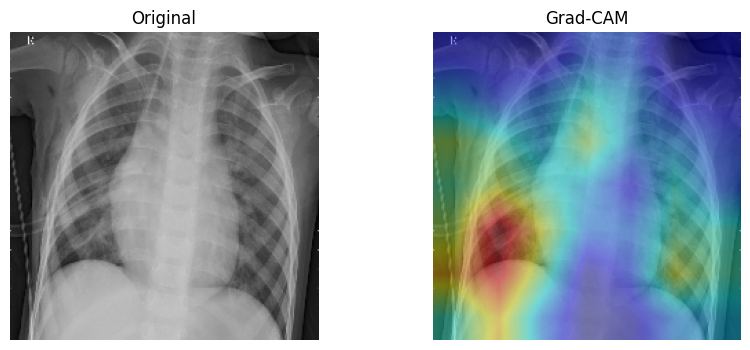

In [69]:
sample_image = '/content/chest_xray/chest_xray/test/PNEUMONIA/person149_bacteria_713.jpeg'
display_gradcam(sample_image, model)

